# Viral proteins in single-cell RNA seq data

[Open in Google Colab](https://colab.research.google.com/github/pachterlab/kb_docs/blob/main/docs/source/translated/notebooks/virus_detection_sc.ipynb)  
Click "Runtime" -> "Run all" to run this notebook.

In this tutorial, we will align single-cell RNA sequencing data collected from Dengue virus (DENV)-infected CEM.NK$^{R}$ cells as well as peripheral blood mononuclear cells (PBMC) data collected from a patient suffering from DENV (during and after infection) to viral RdRP protein sequences. Let's see if we can detect DENV RdRP sequences as expected.

**Workflow reference**:  
Laura Luebbert, Delaney K Sullivan, Maria Carilli, Kristján Eldjárn Hjörleifsson, Alexander Viloria Winnett, Tara Chari, Lior Pachter (2023). [Efficient and accurate detection of viral sequences at single-cell resolution reveals novel viruses perturbing host gene expression](https://www.biorxiv.org/content/10.1101/2023.12.11.571168). *bioRxiv* 2023.12.11.571168; doi: https://doi.org/10.1101/2023.12.11.571168

**Data references:**  
RNA seq data:  
https://www.nature.com/articles/s41598-020-65939-5  
https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA613041&o=acc_s%3Aa  
PalmDB viral protein reference database:  
https://www.nature.com/articles/s41586-021-04332-2  
  
Written by: Laura Luebbert (last updated: January 7<sup>th</sup>, 2025)

In [1]:
# SRR numbers of the sequencing dataset(s) to analyze
srr_numbers = [
    "SRR11321526",
    "SRR11321528",
    "SRR11321027",
    "SRR11321026"
    ]

# Genus and species of the host (separate by "_")
host_species = "homo_sapiens"

# Set this to False to download the complete RNA seq dataset (note: this might exceed the Google Colab disk space)
# With subset_of_data=True, only a subset of the DENV dataset is aligned in this example notebook to decrease runtime and required disk space
subset_of_data = True

# Number of threads to use during alignments
threads = 2

# k-mer length: Increase k for increased specificity (at a potential trade-off with sensitivity)
# k should be an odd integer and should be >=31 for translated alignment
# Since k relates to nucleotides and not amino acids, k corresponds to matching ⌊k/3⌋ amino acids (for k=31, this corresponds to ⌊31/3⌋=10 amino acids)
k = 31

## Install software

In [2]:
!pip install -q ffq gget kb_python==0.29.1 anndata==0.10.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.5/36.5 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB

In [3]:
import anndata
import gget
import glob
import gzip
import json
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import platform
from Bio import SeqIO

%config InlineBackend.figure_format='retina'

In [ ]:
# This step will not be necessary after the next kb release
if k<32:
  # Install kallisto v0.50.0 from source
  # This version performs translated search faster while providing the same results as later versions, but it does not support k>31
  # (the features to increase runtime and support k>31 will be incorporated into the next version of kb, so this step will not be necessary after the next release)
  !git clone https://github.com/pachterlab/kallisto.git --branch v0.50.0
  !cd kallisto && mkdir build && cd build && cmake .. && make
  kallisto = "kallisto/build/src/kallisto"
else:
  # Find the kallisto binary installed automatically with kb (or simply remove the --kallisto arguments below)
  kallisto = glob.glob(f"/usr/local/lib/python*/dist-packages/kb_python/bins/{platform.system().lower()}/kallisto/kallisto_k64")[0]

## Download raw sequencing data
Here, we will use [ffq](https://github.com/pachterlab/ffq) to download the sequencing data from DENV1 infected CEM.NK^R cells (SRR11321027) and the uninfected control (SRR11321026) as well as PBMC data collected from a patient experiencing a DENV infection at fever day -2 (SRR11321526) and 180 (baseline post-infection) (SRR11321528):

In [5]:
%%time

## Get the FTP download links for raw data using ffq and store the results in a json file
srr_numbers = " ".join(srr_numbers)
!ffq $srr_numbers \
    --ftp \
    -o ffq.json

## Load ffq output
f = open("ffq.json")
data_json = json.load(f)
f.close()

## Download raw data using FTP links fetched by ffq
# NOTE: To decrease the runtime and required disk space of this example notebook,
# we will only download the first [gb_to_download] GB of each fastq file when subset_of_data=True
gb_to_download = 3

# Convert GB to bytes
max_bytes = gb_to_download * 1073741824
# Download data
for dataset in data_json:
    url = dataset["url"]

    if subset_of_data:
      !curl -r 0-$max_bytes -O $url
    else:
      !curl -O $url

# Remove unnecessary file to save disk space
!rm SRR11321528.fastq.gz

[2025-01-10 15:00:38,840]    INFO Parsing run SRR11321526
[2025-01-10 15:00:40,240]    INFO Parsing run SRR11321528
[2025-01-10 15:00:41,497]    INFO Parsing run SRR11321027
[2025-01-10 15:00:42,746]    INFO Parsing run SRR11321026
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3072M  100 3072M    0     0  44.8M      0  0:01:08  0:01:08 --:--:-- 22.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3072M  100 3072M    0     0  49.8M      0  0:01:01  0:01:01 --:--:-- 51.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3072M  100 3072M    0     0  49.1M      0  0:01:02  0:01:02 --:--:-- 51.0M
  % Total    % Received % Xferd  Average Speed   Time    

## Download the viral protein reference sequences
In this case, we are using a version of the [PalmDB database v1](https://github.com/ababaian/palmdb) that was optimized for viral sequence detection with kallisto as described in [this manuscript](https://www.biorxiv.org/content/10.1101/2023.12.11.571168). These files are stored in the [GitHub repository](https://github.com/pachterlab/LSCHWCP_2023/tree/main) accompanying the manuscript.

In [6]:
# Download the virus ID to taxonomy mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
# Download the customized transcripts to gene mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
# Download the RdRP amino acid sequences
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_rdrp_seqs.fa

--2025-01-10 15:10:22--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19705497 (19M) [text/plain]
Saving to: ‘ID_to_taxonomy_mapping.csv’

ID_to_taxonomy_mapp 100%[===================>]  18.79M  --.-KB/s    in 0.06s   

2025-01-10 15:10:23 (318 MB/s) - ‘ID_to_taxonomy_mapping.csv’ saved [19705497/19705497]

--2025-01-10 15:10:23--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request s

## Build a reference index from the viral protein sequences and mask host (here, human) sequences

In addition to building a reference index from the protein sequences, we also want to mask host (in this case, human) sequences. **For a more conservative host masking workflow that incorporates an additional step for the removal of host sequences, see [this notebook](https://github.com/pachterlab/LSCHWCP_2023/blob/main/Notebooks/align_macaque_PBMC_data/7_virus_host_captured_dlist_cdna_dna/1_align_captured_dlist_cdna_dna.ipynb).**

The [`--aa` argument](https://kallisto.readthedocs.io/en/latest/translated/pseudoalignment.html) tells `kb` that this is an amino acid reference.

The [`--d-list` argument](https://kallisto.readthedocs.io/en/latest/index/index_generation.html#the-d-list) is the path to the host genome/transcriptome. These sequences will be masked in the index. Here, we are using [`gget ref`](https://pachterlab.github.io/gget/en/ref.html) to fetch the latest human genome and transcriptome from Ensembl.

We are using `--workflow custom` here since we do not have a .gtf file for the PalmDB fasta file.

`--kallisto` provides the path to the kallisto binary v0.50.0 (if `k` ≤ 31), which we installed above. This argument can be omitted to use the kallisto binary included in kb.

Building the index can take some time, depending on the number of threads used and the size of the D-list (here, ~20 min), but it only needs to be done once.

In [7]:
# Download the host reference genome and transcriptome from Ensembl
!gget ref -w cdna,dna -d $host_species

# Concatenate host genome and transcriptome into one file
host_genome = glob.glob("*.dna*.fa.gz")[0]
host_transcriptome = glob.glob("*.cdna.all.fa.gz")[0]
host_genome_transciptome = f"{host_species}.cdna_dna.fa.gz"
!cat $host_genome $host_transcriptome > $host_genome_transciptome

15:10:30 - INFO - Fetching reference information for homo_sapiens from Ensembl release: 113.
{
    "homo_sapiens": {
        "transcriptome_cdna": {
            "ftp": "http://ftp.ensembl.org/pub/release-113/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz",
            "ensembl_release": 113,
            "release_date": "2024-08-15",
            "release_time": "14:44",
            "bytes": "76M"
        },
        "genome_dna": {
            "ftp": "http://ftp.ensembl.org/pub/release-113/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz",
            "ensembl_release": 113,
            "release_date": "2024-08-15",
            "release_time": "20:18",
            "bytes": "841M"
        }
    }
}
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75.9M  100 75.9M    0     0  34.4M      0  0:00:02  0:00:02 --:--:-- 34.4M
  % Total    % Received %

In [8]:
%%time
# Generate the viral protein reference index with masked host sequences using kallisto
reference_index = f"palmdb_{host_species}_dlist_cdna_dna.idx"

!kb ref \
    --kallisto $kallisto \
    --verbose \
    -t $threads \
    --aa \
    -k $k \
    --workflow custom \
    --d-list $host_genome_transciptome \
    -i $reference_index \
    palmdb_rdrp_seqs.fa

[2025-01-10 15:11:01,539]   DEBUG [main] Printing verbose output
[2025-01-10 15:11:03,746]   DEBUG [main] kallisto binary located at /content/kallisto/build/src/kallisto
[2025-01-10 15:11:03,746]   DEBUG [main] bustools binary located at /usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools
[2025-01-10 15:11:03,746]   DEBUG [main] Creating `tmp` directory
[2025-01-10 15:11:03,746]   DEBUG [main] Namespace(list=False, command='ref', tmp=None, keep_tmp=False, verbose=True, i='palmdb_homo_sapiens_dlist_cdna_dna.idx', g=None, f1=None, include_attribute=None, exclude_attribute=None, f2=None, c1=None, c2=None, d=None, k=31, t=2, d_list='homo_sapiens.cdna_dna.fa.gz', d_list_overhang=1, aa=True, workflow='custom', distinguish=False, make_unique=False, overwrite=False, kallisto='kallisto/build/src/kallisto', bustools='/usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools', opt_off=False, fasta='palmdb_rdrp_seqs.fa', gtf=None, feature=None, no_mi

Alternatively, you can download a precomputed PalmDB reference index for use with `kb` in which the human (or mouse) genome and transcriptome were masked. You can find links to all available precomputed reference indeces [here](https://github.com/pachterlab/LSCHWCP_2023/tree/main/precomputed_refs).  
**Note:** These indeces were computed with `k=31`.

In [9]:
# # Download precomputed index with masked human genome and transcriptome
# k=31
# !wget https://data.caltech.edu/records/sh33z-hrx98/files/palmdb_human_dlist_cdna_dna.idx?download=1
# !mv palmdb_human_dlist_cdna_dna.idx?download=1 palmdb_human_dlist_cdna_dna.idx

## Align data using kallisto translated search

Create a batch.txt file so we can run all fastq files simultaneously (to learn more about batch files, see Box 7 in the [Protocols paper](https://www.biorxiv.org/content/10.1101/2023.11.21.568164v2.full.pdf)) (to keep track of which cell barcodes belonged to which SRR file, we will activate the `--batch-barcodes` option in the alignment step below):

In [10]:
%%time

samples = srr_numbers.split(" ")

# NOTE: To decrease the runtime and disk space of this example notebook,
# we will only align the top [n_seq_to_keep[i]] sequences in each fastq file when subset_of_data=True
n_seq_to_keep = [
  20000000,
  20000000,
  5000000, # No need to keep as many reads for the cell line samples as viral read % is higher
  5000000
]

with open("batch.txt", "w") as batch_file:
  for i, sample in enumerate(samples):
    R1 = f"/content/{sample}_1.fastq.gz"
    R2 = f"/content/{sample}_2.fastq.gz"

    if subset_of_data:
      # Shorten fastq files (skip this step during a real analysis)
      n_rows_to_keep = n_seq_to_keep[i] * 4
      R1_short = R1.split(".fastq.gz")[0] + "_short.fastq"
      R2_short = R2.split(".fastq.gz")[0] + "_short.fastq"

      !zcat $R1 | head -$n_rows_to_keep > $R1_short
      !zcat $R2 | head -$n_rows_to_keep > $R2_short
      # Delete original files to save disk space
      !rm $R1 $R2

      # Write batch file in the following format:
      # sample_name \t R1_filepath \t R2_filepath
      batch_file.write(sample + "\t" + R1_short + "\t" + R2_short + "\n")

    else:
      batch_file.write(sample + "\t" + R1 + "\t" + R2 + "\n")

CPU times: user 3.07 s, sys: 458 ms, total: 3.53 s
Wall time: 7min 41s


#### Align fastqs using kallisto translated search:  
The `--aa` argument tells `kb` that this is an amino acid reference index.  
The [`-x` argument](https://kallisto.readthedocs.io/en/latest/sc/technologies.html) tells `kb` where to find the cell barcodes and UMIs in the data. Here, we set it to `10xv2` because this data was generated using the Chromium Single-Cell 5′ Reagent version 2 kit.  
The `--h5ad` flag generates a .h5ad file from the count matrix.
  
**NOTE for paired read data:** kallisto translated search currently does not yet support the simultaneous alignment of paired reads, so `parity` should always be set to 'single' (`--parity single`) and the R1 and R2 files obtained using paired read sequencing should be aligned separately. The resulting matrices from the R1 and R2 reads should provide similar viral counts.

In [11]:
%%time
out_folder = "kb_output"

!kb count \
    --kallisto $kallisto \
    --verbose \
    -t $threads \
    --aa \
    -k $k \
    -x 10xv2 \
    --parity single \
    -i $reference_index \
    -g palmdb_clustered_t2g.txt \
    --h5ad \
    -o $out_folder \
    --batch-barcodes \
    batch.txt

[2025-01-10 15:52:50,983]   DEBUG [main] Printing verbose output
[2025-01-10 15:52:53,191]   DEBUG [main] kallisto binary located at /content/kallisto/build/src/kallisto
[2025-01-10 15:52:53,192]   DEBUG [main] bustools binary located at /usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools
[2025-01-10 15:52:53,192]   DEBUG [main] Creating `kb_output/tmp` directory
[2025-01-10 15:52:53,194]   DEBUG [main] Namespace(list=False, command='count', tmp=None, keep_tmp=False, verbose=True, i='palmdb_homo_sapiens_dlist_cdna_dna.idx', g='palmdb_clustered_t2g.txt', x='10xv2', o='kb_output', num=False, w=None, r=None, t=2, m='2G', strand=None, inleaved=False, genomebam=False, aa=True, gtf=None, chromosomes=None, workflow='standard', em=False, mm=False, tcc=False, filter=None, filter_threshold=None, c1=None, c2=None, overwrite=False, dry_run=False, batch_barcodes=True, loom=False, h5ad=True, loom_names='barcode,target_name', sum='none', cellranger=False, gene_names=False, 

## Load the generated count matrix

In [12]:
# Open count matrix (AnnData object in h5ad format)
adata = anndata.read_h5ad(f"{out_folder}/counts_unfiltered/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 15369 × 99228

In [13]:
# 'barcode' here includes batch/sample barcode (first 16 characters) + cell barcode
adata.obs

""
barcode
AAAAAAAAAAAAAAAAAAACCTGAGATGTCGG
AAAAAAAAAAAAAAAAAAACCTGAGTGAATTG
AAAAAAAAAAAAAAAAAAACCTGTCAATACCG
AAAAAAAAAAAAAAAAAAACCTGTCCACTCCA
AAAAAAAAAAAAAAAAAAACCTGTCCATGCTC
...
AAAAAAAAAAAAAAATTTTGCGCCAACGATGG
AAAAAAAAAAAAAAATTTTGGTTAGGTAAACT
AAAAAAAAAAAAAAATTTTGGTTTCTCTGAGA


Use the sample barcodes to add a column with the original SRR file for each cell:

In [14]:
# Load the sample/batch barcodes
b_file = open("kb_output/matrix.sample.barcodes")
barcodes = b_file.read().splitlines()
b_file.close()

# Load the sample/batch names
s_file = open("kb_output/matrix.cells")
samples = s_file.read().splitlines()
s_file.close()

# Create dataframe that maps sample barcodes to sample names
bc2sample_df = pd.DataFrame()
bc2sample_df["sample_barcode"] = barcodes
bc2sample_df["srr"] = samples

# Add sample name to AnnData object
adata.obs["barcode"] = adata.obs.index.values
adata.obs["sample_barcode"] = [bc[:-16] for bc in adata.obs.index.values]
adata.obs["cell_barcode"] = [bc[-16:] for bc in adata.obs.index.values]
adata.obs = adata.obs.merge(bc2sample_df, on="sample_barcode", how="left").set_index("cell_barcode", drop=False)
adata.obs

,barcode,sample_barcode,cell_barcode,srr
cell_barcode,,,,
AAACCTGAGATGTCGG,AAAAAAAAAAAAAAAAAAACCTGAGATGTCGG,AAAAAAAAAAAAAAAA,AAACCTGAGATGTCGG,SRR11321526
AAACCTGAGTGAATTG,AAAAAAAAAAAAAAAAAAACCTGAGTGAATTG,AAAAAAAAAAAAAAAA,AAACCTGAGTGAATTG,SRR11321526
AAACCTGTCAATACCG,AAAAAAAAAAAAAAAAAAACCTGTCAATACCG,AAAAAAAAAAAAAAAA,AAACCTGTCAATACCG,SRR11321526
AAACCTGTCCACTCCA,AAAAAAAAAAAAAAAAAAACCTGTCCACTCCA,AAAAAAAAAAAAAAAA,AAACCTGTCCACTCCA,SRR11321526
AAACCTGTCCATGCTC,AAAAAAAAAAAAAAAAAAACCTGTCCATGCTC,AAAAAAAAAAAAAAAA,AAACCTGTCCATGCTC,SRR11321526
...,...,...,...,...
TTTGCGCCAACGATGG,AAAAAAAAAAAAAAATTTTGCGCCAACGATGG,AAAAAAAAAAAAAAAT,TTTGCGCCAACGATGG,SRR11321026
TTTGGTTAGGTAAACT,AAAAAAAAAAAAAAATTTTGGTTAGGTAAACT,AAAAAAAAAAAAAAAT,TTTGGTTAGGTAAACT,SRR11321026
TTTGGTTTCTCTGAGA,AAAAAAAAAAAAAAATTTTGGTTTCTCTGAGA,AAAAAAAAAAAAAAAT,TTTGGTTTCTCTGAGA,SRR11321026


In [15]:
# Create dataframe with a label for each SRR library
samples = [
    'SRR11321526',
    'SRR11321528',
    'SRR11321027',
    'SRR11321026'
    ]

# Label corresponding to each SRR library (samples)
labels = [
    'Patient PBMC\n(fever day -2)',
    'Patient PBMC\n(post-infection control)',
    'DENV-infected CEM.NK$^R$',
    'Uninfected\nControl (CEM.NK$^R$)'
    ]

metadata_df = pd.DataFrame()
metadata_df["SRR"] = samples
metadata_df["label"] = labels
metadata_df

,SRR,label
0,SRR11321526,Patient PBMC\n(fever day -2)
1,SRR11321528,Patient PBMC\n(post-infection control)
2,SRR11321027,DENV-infected CEM.NK$^R$
3,SRR11321026,Uninfected\nControl (CEM.NK$^R$)


## Plot counts for Dengue virus (DENV) in each sample
Find the virus IDs for Dengue virus in the PalmDB viral protein reference:

In [16]:
# Load the PalmDB virus ID to virus taxonomy mapping
u_tax_csv = "ID_to_taxonomy_mapping.csv"
tax_df = pd.read_csv(u_tax_csv)

# Find the reference IDs for Dengue virus RdRPs
# Note: Only the rep_ID (representative ID) will occur in the count matrix
tax_df[tax_df["species"].str.contains("Dengue virus")]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
7298,u1010,u1010,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,Dengue virus,+ssRNA
7299,u1014,u1010,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,Dengue virus,+ssRNA
7300,u1015,u1010,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,Dengue virus,+ssRNA
7301,u1025,u1010,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,Dengue virus,+ssRNA
7302,u10313,u1010,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,Dengue virus,+ssRNA
...,...,...,...,...,...,...,...,...,...
8360,u9796,u1010,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,Dengue virus,+ssRNA
8361,u9846,u1010,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,Dengue virus,+ssRNA
8362,u9911,u1010,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,Dengue virus,+ssRNA
8363,u9935,u1010,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,Dengue virus,+ssRNA


In [17]:
# Target virus IDs to plot (here, Dengue virus)
target_virus = "Dengue virus"
target_ids = tax_df[tax_df["species"].str.contains(target_virus)]["rep_ID"].unique()
target_ids

array(['u1010'], dtype=object)

Create bar plot showing raw counts for DENV:

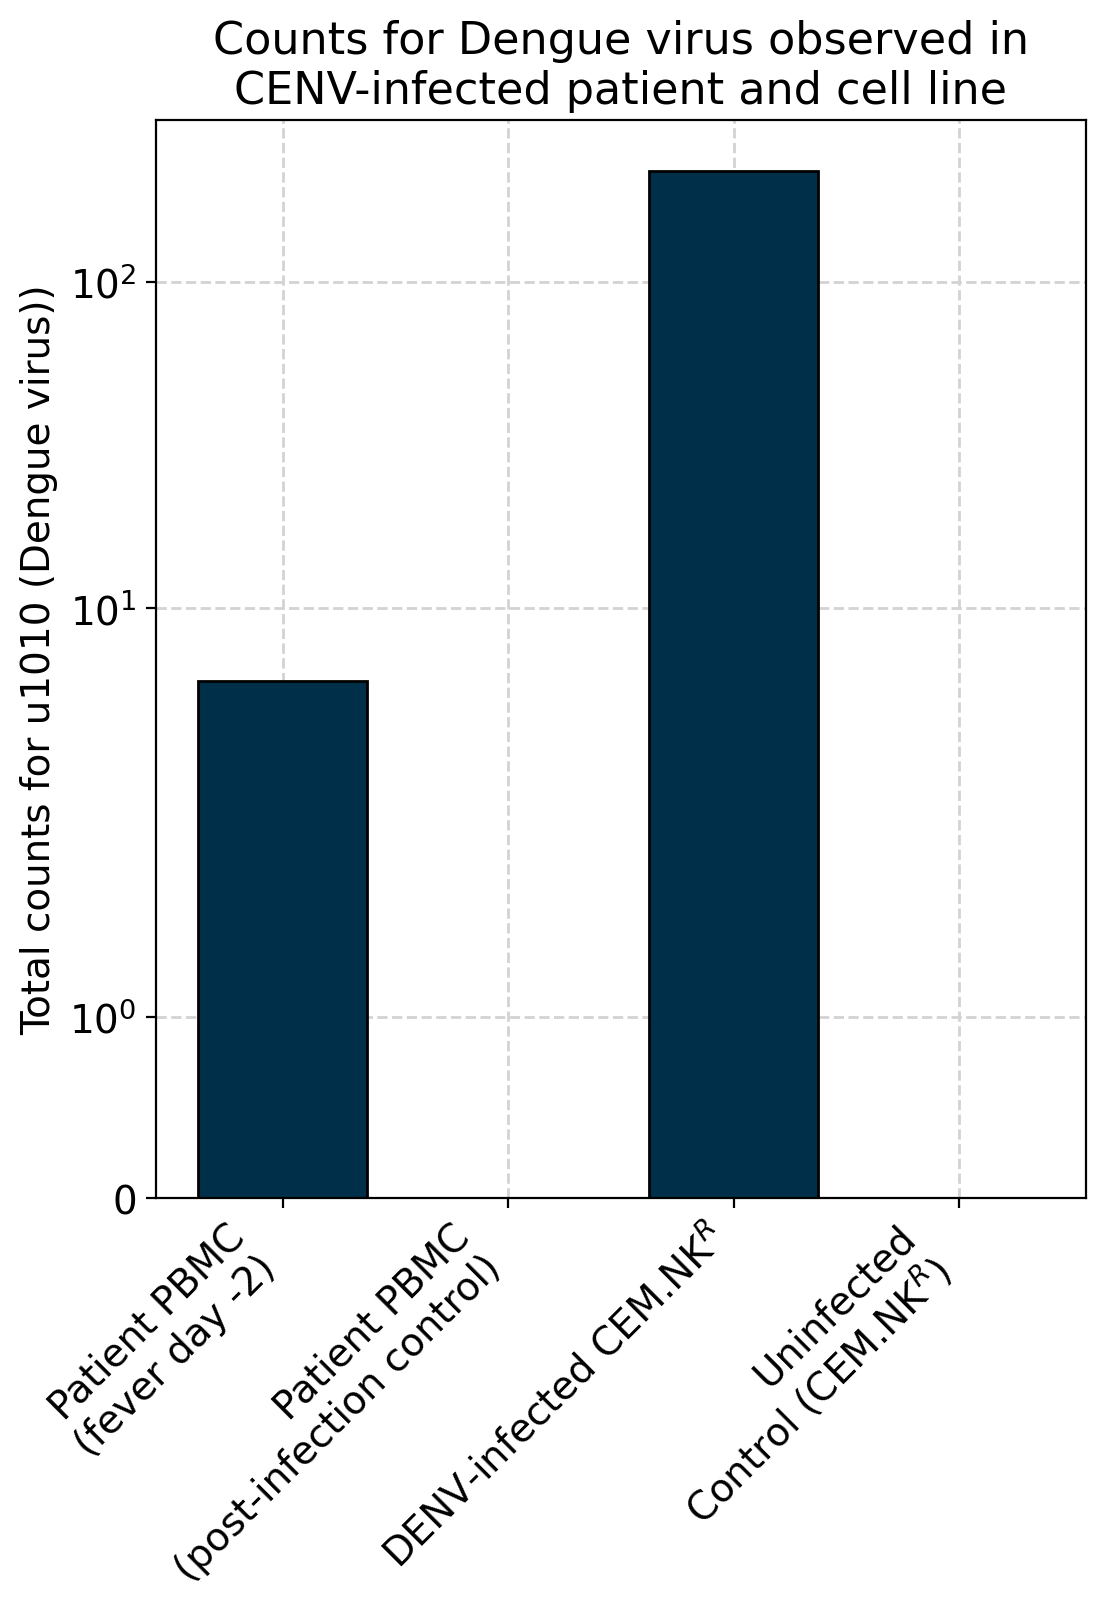

In [18]:
fig, ax = plt.subplots(figsize=(6, 7))
fontsize = 14
width = 0.75

counts = []
for sample in metadata_df["SRR"].values:
    counts.append(adata.X[adata.obs["srr"].str.contains(sample), adata.var.index.isin(target_ids)].sum())

x = np.arange(len(metadata_df["SRR"].values))

ax.bar(x, counts, width=width, color="#003049", edgecolor="black")

# Adjust figure labels and axes
ax.set_title(f"Counts for Dengue virus observed in\nCENV-infected patient and cell line", fontsize=fontsize+2)
ax.set_yscale("symlog")
ax.set_ylabel(f"Total counts for {target_ids[0]} (Dengue virus))", fontsize=fontsize)
# ax.set_xlabel("Sample", fontsize=fontsize)
ax.set_xticks(x, metadata_df["label"].values, rotation=45, ha="right")
ax.tick_params(axis="both", labelsize=fontsize)
ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

# Save figure
plt.savefig("denv_rdrp_count.png", dpi=300, bbox_inches="tight")

fig.show()

In [19]:
# NOTE: These counts are low since we only aligned a small subset of the data in this example notebook
counts

[6.0, 0.0, 219.0, 0.0]

## Visualize other virus-like sequences observed in the dataset
When interpreting the presence of other virus- or RdRP-like sequences (each identified by its own virus ID), keep in mind that there will likely be many RdRP-like sequences introduced by contamination of laboratory reagents. A (non-comprehensive) list of virus IDs observed in blank sequencing data is available [here](https://github.com/pachterlab/LSCHWCP_2023/blob/main/viruses_in_blank_reagents/total_raw_count_per_virus_id_in_laboratory_reagents.csv) and we will download it below for comparison to the virus IDs observed in our dataset. Another indication that a sequence may have originated from sample contamination is its uniform presence across all sequenced samples.

In [20]:
# Download list of virus IDs seen in blank sequencing reagents
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/refs/heads/main/viruses_in_blank_reagents/total_raw_count_per_virus_id_in_laboratory_reagents.csv
blank_df = pd.read_csv("total_raw_count_per_virus_id_in_laboratory_reagents.csv")
blank_df

--2025-01-10 20:22:00--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/refs/heads/main/viruses_in_blank_reagents/total_raw_count_per_virus_id_in_laboratory_reagents.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54642 (53K) [text/plain]
Saving to: ‘total_raw_count_per_virus_id_in_laboratory_reagents.csv’

total_raw_count_per 100%[===================>]  53.36K  --.-KB/s    in 0.002s  

2025-01-10 20:22:01 (33.5 MB/s) - ‘total_raw_count_per_virus_id_in_laboratory_reagents.csv’ saved [54642/54642]



,count,virus
0,5374210.0,u172514
1,4301784.0,u226460
2,752771.0,u237705
3,456424.0,u202260
4,359783.0,u223701
...,...,...
4573,1.0,u169611
4574,1.0,u41840
4575,1.0,u169761
4576,1.0,u169999


Plot the top 20 virus IDs observed in this dataset (raw counts are normalized to the total number of reads in each sample, and **virus IDs also observed in blank sequencing reagents are marked in red**):

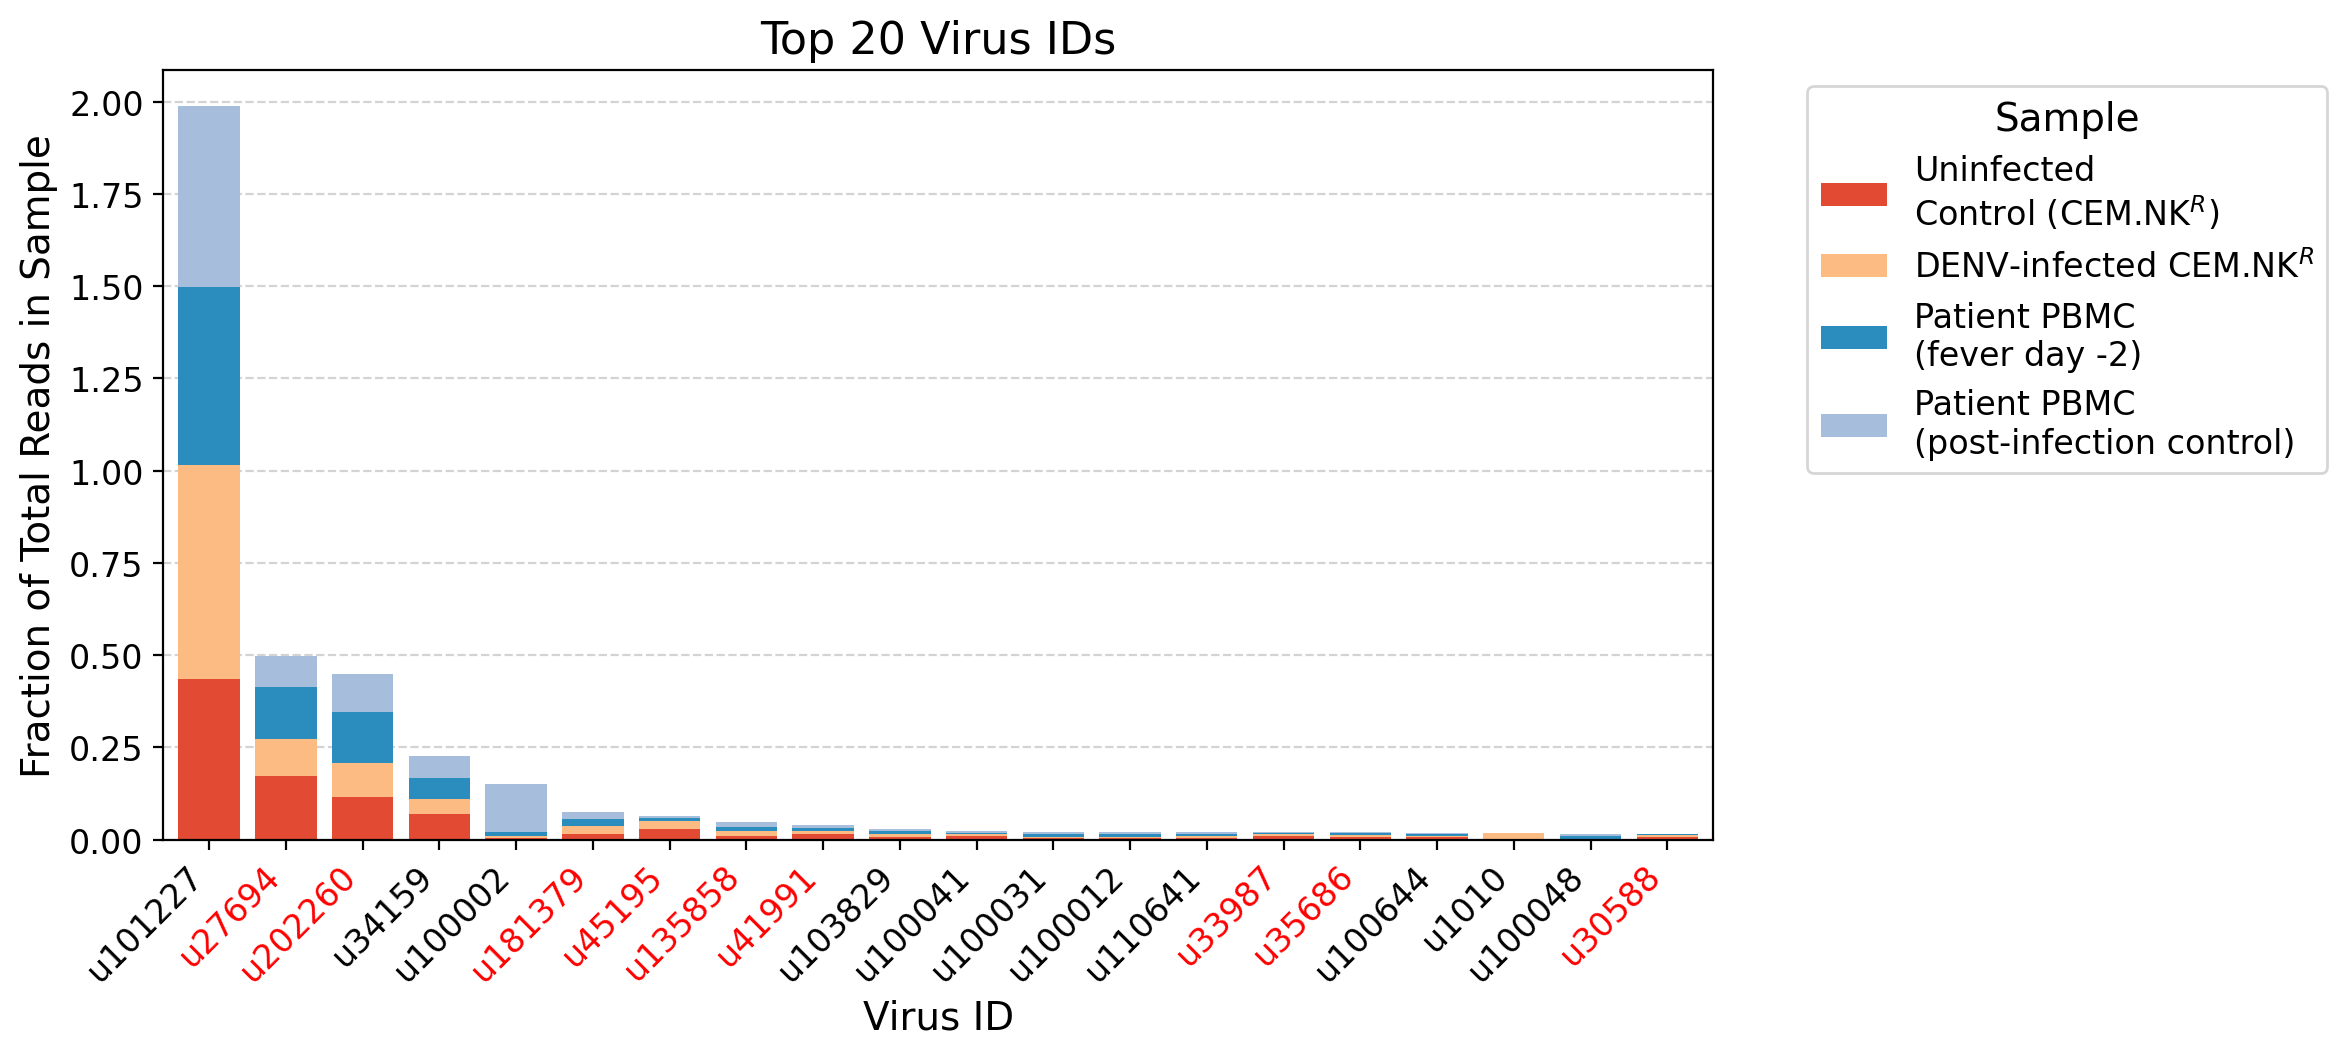

In [21]:
# Plot the top 20 virus IDs (counts will be normalized to total counts in each SRR library)
def plot_top_virs_stacked_bar(adata, top_n=20):
    # Convert sparse matrix to dense if needed
    counts_matrix = adata.X
    if not isinstance(counts_matrix, np.ndarray):
        counts_matrix = counts_matrix.toarray()

    # Create a DataFrame with counts and group by SRR library
    df_counts = pd.DataFrame(counts_matrix, columns=adata.var_names, index=adata.obs["srr"])
    grouped_counts = df_counts.groupby(level=0).sum()

    # Normalize counts by total read depth per SRR library
    grouped_counts_normalized = grouped_counts.div(grouped_counts.sum(axis=1), axis=0)

    # Sum normalized counts across all SRR libraries for each virus
    vir_totals = grouped_counts_normalized.sum(axis=0)

    # Get the top N viruses across all SRR libraries
    top_vir_indices = np.argsort(vir_totals)[-top_n:][::-1]
    top_virs = grouped_counts_normalized.columns[top_vir_indices]
    top_counts = grouped_counts_normalized[top_virs]

    # Create a stacked bar plot
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ['#e34a33', '#fdbb84', '#2b8cbe', '#a6bddb'] * (len(top_counts) // 6 + 1)
    fontsize = 14

    bar_bottom = np.zeros(len(top_virs))
    for i, (srr_id, row_counts) in enumerate(top_counts.iterrows()):
        ax.bar(
            top_virs,
            row_counts,
            bottom=bar_bottom,
            color=colors[i],
            label=metadata_df[metadata_df["SRR"] == srr_id]["label"].values[0]
        )
        bar_bottom += row_counts

    # Adjust figure labels and axes
    ax.set_title(f"Top {top_n} Virus IDs", fontsize=fontsize+2)
    ax.set_xlabel("Virus ID", fontsize=fontsize)
    ax.set_ylabel("Fraction of Total Reads in Sample", fontsize=fontsize)
    ax.set_xticklabels(top_virs, rotation=45, ha='right')
    # Mark virus IDs that have been observed in blank sequencing reagents in red
    for i, label in enumerate(top_virs):
        if label in blank_df["virus"].values:
            ax.get_xticklabels()[i].set_color('red')
    ax.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=fontsize-2, title_fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
    ax.grid(axis='y', linestyle='--', color="lightgrey", alpha=1)
    ax.set_axisbelow(True)
    ax.margins(x=0.01)

    # Save figure
    fig.savefig("top_virus_IDs_per_sample.png", dpi=300, bbox_inches="tight")

    fig.show()

    return top_virs

top_virs = plot_top_virs_stacked_bar(adata, top_n=20)

Show the predicted taxonomies for each virus ID shown in the plot above (these are the species-like operational taxonomic units (OTUs) provided by PalmDB):

In [22]:
top_vir_tax = tax_df[tax_df["rep_ID"].isin(top_virs)][tax_df.columns[1:]].drop_duplicates()
top_vir_tax['rep_ID'] = pd.Categorical(top_vir_tax['rep_ID'], categories=top_virs, ordered=True)
top_vir_tax = top_vir_tax.sort_values('rep_ID')
top_vir_tax

,rep_ID,phylum,class,order,family,genus,species,strandedness
212430,u101227,Pisuviricota,Pisoniviricetes,Picornavirales,Picornaviridae,.,.,+ssRNA
34276,u27694,Peploviricota,Herviviricetes,Herpesvirales,Herpesviridae,Varicellovirus,Bubaline alphaherpesvirus 1,dsDNA
263358,u202260,.,.,.,.,.,.,unknown
35782,u34159,.,.,.,.,.,.,unknown
66423,u100002,Lenarviricota,Allassoviricetes,Levivirales,.,.,.,+ssRNA
256038,u181379,.,.,.,.,.,.,unknown
39629,u45195,.,.,.,.,.,.,unknown
238847,u135858,.,.,.,.,.,.,unknown
38543,u41991,.,.,.,.,.,.,unknown
219921,u103829,Negarnaviricota,Insthoviricetes,Articulavirales,Orthomyxoviridae,.,.,-ssRNA


To confirm the presence of a known virus for which a reference genome is available, you can align the data to the viral (nucleotide) reference genome using the standard `kb` workflow (simply omit the `--aa` flag in the `kb ref` and `kb count` commands and supply the viral reference genome to `kb ref` instead of the PalmDB protein reference).  

If this approach fails or no reference genome is available, use `kb extract` to extract raw reads that aligned to a given virus ID for further analysis (such as BLAST alignment):

In [23]:
# Sequences that matched to [vir_ids_to_extract] will be extracted
# Here, we will extract reads that mapped to the virus ID u101227
# u101227 is the virus ID with the most counts across all samples so we might like to find out more about it
vir_ids_to_extract = ["u101227"]

# Provide a single fastq file to extract sequences from (here, we are using "Patient PBMC (post-infection control)")
fastq_file = "/content/SRR11321528_1_short.fastq"

In [24]:
%%time
# Extract sequences using kb extract
outfolder_extract = "extracted_seqs"
targets = " ".join(vir_ids_to_extract)

!kb extract \
    --kallisto $kallisto \
    --verbose \
    -t $threads \
    --aa \
    -k $k \
    -g palmdb_clustered_t2g.txt \
    -i $reference_index \
    -ts $targets \
    -o $outfolder_extract \
    $fastq_file

[2025-01-10 20:22:36,217]   DEBUG [main] Printing verbose output
[2025-01-10 20:22:38,426]   DEBUG [main] kallisto binary located at /content/kallisto/build/src/kallisto
[2025-01-10 20:22:38,427]   DEBUG [main] bustools binary located at /usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools
[2025-01-10 20:22:38,427]   DEBUG [main] Creating `extracted_seqs/tmp` directory
[2025-01-10 20:22:38,428]   DEBUG [main] Namespace(list=False, command='extract', tmp=None, keep_tmp=False, verbose=True, fastq='/content/SRR11321528_1_short.fastq', i='palmdb_homo_sapiens_dlist_cdna_dna.idx', targets=['u101227'], target_type='gene', extract_all=False, extract_all_fast=False, extract_all_unmapped=False, mm=False, g='palmdb_clustered_t2g.txt', o='extracted_seqs', t=2, strand=None, aa=True, N=None, kallisto='kallisto/build/src/kallisto', bustools='/usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools', opt_off=False, k=31)
[2025-01-10 20:22:41,916]    INFO

In [25]:
# Grab the reads extracted by kb extract for each virus ID
def get_all_sequences(fastq_file):
    """Extract all sequences from a gzipped FASTQ file."""
    sequences = []
    with gzip.open(fastq_file, "rt") as f:
        for record in SeqIO.parse(f, "fastq"):
            sequences.append(str(record.seq))
    return sequences

extracted_seqs_dict = {}
for vir_id in vir_ids_to_extract:
    # Grab the reads from the fastq file returned by kb extract
    seqs = get_all_sequences(f"{outfolder_extract}/{vir_id}/1.fastq.gz")
    # Save the extracted reads for each virus ID in a dictionary
    extracted_seqs_dict[vir_id] = seqs

BLAST the first read extracted for virus ID u101227 using [`gget blast`](https://pachterlab.github.io/gget/en/blast.html) to see which known reference sequences it aligns to:

In [26]:
# BLAST the first read extracted for u101227 using gget
seq_idx = 0
virus_id = "u101227"

raw_read = extracted_seqs_dict[virus_id][seq_idx]

blast_df = gget.blast(raw_read)
blast_df

INFO:gget.utils:Sequence recognized as nucleotide sequence.
INFO:gget.utils:BLAST will use program 'blastn' with database 'nt'.
INFO:gget.utils:BLAST initiated with search ID S3781DRZ013. Estimated time to completion: 30 seconds.
INFO:gget.utils:Retrieving results...
/usr/local/lib/python3.10/dist-packages/gget/gget_blast.py:327: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_df = pd.read_html(str(dsc_table))[0]


,Description,Scientific Name,Common Name,Taxid,Max Score,Total Score,Query Cover,E value,Per. Ident,Acc. Len,Accession
0,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus 2,NaN,2697049,84.2,84.2,40%,4.000000e-12,91.67%,29567,OY708460.1
1,Gossypium raimondii isolate Gr291 retrotranspo...,Gossypium raimondii,Peruvian cotton,29730,71.3,71.3,45%,3.000000e-08,85.29%,1708,KT895861.1
2,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus 2,NaN,2697049,58.4,58.4,23%,3.000000e-04,97.06%,29816,OY714418.1
3,"Synthetic construct LB106 DNA, synthetic long-...",synthetic construct,NaN,32630,54.7,54.7,19%,3.000000e-03,100.00%,572,LC597715.1
4,"Gastrodia elata chromosome GE13 mitochondrion,...",Gastrodia elata,NaN,91201,52.8,52.8,19%,1.200000e-02,100.00%,34420,OP441103.1


BLAST a few more of the extracted sequences to see if the BLAST results reproduce:

In [27]:
# Set the seed for reproducibility
np.random.seed(29)

# Randomly select indices for three of the extracted sequences
seq_idxs = np.random.randint(0, 200, size=3)
seq_idxs

array([115,  34,  40])

In [28]:
gget.blast(extracted_seqs_dict[virus_id][seq_idxs[0]], limit=5)

INFO:gget.utils:Sequence recognized as nucleotide sequence.
INFO:gget.utils:BLAST will use program 'blastn' with database 'nt'.
INFO:gget.utils:BLAST initiated with search ID S3792G4W016. Estimated time to completion: 30 seconds.
INFO:gget.utils:Retrieving results...
/usr/local/lib/python3.10/dist-packages/gget/gget_blast.py:327: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_df = pd.read_html(str(dsc_table))[0]


,Description,Scientific Name,Common Name,Taxid,Max Score,Total Score,Query Cover,E value,Per. Ident,Acc. Len,Accession
0,"Homo sapiens ribosomal protein S7, mRNA (cDNA ...",Homo sapiens,human,9606,152,152,58%,1.000000e-32,97.73%,701,BC002866.2
1,PREDICTED: Gorilla gorilla gorilla ribosomal p...,Gorilla gorilla gorilla,western lowland gorilla,9595,152,152,58%,1.000000e-32,97.73%,752,XM_004028779.4
2,"Homo sapiens ribosomal protein S7 (RPS7), mRNA",Homo sapiens,human,9606,152,152,58%,1.000000e-32,97.73%,732,NM_001011.4
3,"Homo sapiens ribosomal protein S7, mRNA (cDNA ...",Homo sapiens,human,9606,152,152,58%,1.000000e-32,97.73%,735,BC061901.1
4,"Homo sapiens cDNA, FLJ92055, Homo sapiens ribo...",Homo sapiens,human,9606,148,148,53%,2.000000e-31,100.00%,629,AK311794.1


In [29]:
gget.blast(extracted_seqs_dict[virus_id][seq_idxs[1]], limit=5)

INFO:gget.utils:Sequence recognized as nucleotide sequence.
INFO:gget.utils:BLAST will use program 'blastn' with database 'nt'.
INFO:gget.utils:BLAST initiated with search ID S37A13T4013. Estimated time to completion: 30 seconds.
INFO:gget.utils:Retrieving results...
/usr/local/lib/python3.10/dist-packages/gget/gget_blast.py:327: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_df = pd.read_html(str(dsc_table))[0]


,Description,Scientific Name,Common Name,Taxid,Max Score,Total Score,Query Cover,E value,Per. Ident,Acc. Len,Accession
0,"Homo sapiens SPT3 homolog, SAGA and STAGA comp...",Homo sapiens,human,9606,124,124,44%,3.000000e-24,100.00%,4120,NM_001261823.2
1,Homo sapiens H3K27ac hESC enhancer GRCh37_chr6...,Homo sapiens,human,9606,124,124,44%,3.000000e-24,100.00%,744,NG_108374.1
2,"PREDICTED: Homo sapiens SPT3 homolog, SAGA and...",Homo sapiens,human,9606,124,124,44%,3.000000e-24,100.00%,1198,XR_007059346.1
3,"Homo sapiens SPT3 homolog, SAGA and STAGA comp...",Homo sapiens,human,9606,124,124,44%,3.000000e-24,100.00%,4282,NM_001350324.2
4,Homo sapiens RUNX family transcription factor ...,Homo sapiens,human,9606,124,124,44%,3.000000e-24,100.00%,229766,NG_008020.2


In [30]:
gget.blast(extracted_seqs_dict[virus_id][seq_idxs[2]], limit=5)

INFO:gget.utils:Sequence recognized as nucleotide sequence.
INFO:gget.utils:BLAST will use program 'blastn' with database 'nt'.
INFO:gget.utils:BLAST initiated with search ID S37B10BF013. Estimated time to completion: 30 seconds.
INFO:gget.utils:Retrieving results...
ERROR:gget.utils:No significant similarity found for search S37B10BF013. If your sequence is very short, try increasing the 'expect' argument.


Some of the reads that aligned to u101227 BLASTed to SARS-CoV2 sequences. Given that u101227 was observed uniformly in all samples, which included two samples from patient PBMCs and two from a cell line, it is possible that these viral sequences were introduced by sample contamination. Considering that the dataset was published in 2020, if the presence of a coronavirus is confirmed, it is possible that the researcher handling the samples was infected with SARS-CoV2 or a related virus, which could have led to the presence of these sequences. On the other hand, the predicted taxonomy for u101227 is *Picornaviridae*, which includes disease-causing viruses like Enteroviruses. If this virus does not have a reference genome available, the BLAST results will not be very reliable.

We can align the dataset to one of the SARS-CoV2 reference genomes by rerunnning the `kb ref` and `kb count` commands from above, but providing the virus reference genome and omitting the `--aa` flag since this is now a nucleotide reference (instead of a protein reference):

In [31]:
# Download SARS-CoV2 reference genome from NCBI
# Finding the correct reference genome for the virus present in this dataset might take several tries and I would recommend alingning to all available reference genomes for a given virus
# We will perform an alignment to a single SARS-CoV2 reference genome here as an exampe
!wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.fna.gz
!wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.gtf.gz

--2025-01-10 22:21:53--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9591 (9.4K) [application/x-gzip]
Saving to: ‘GCF_009858895.2_ASM985889v3_genomic.fna.gz’

GCF_009858895.2_ASM 100%[===================>]   9.37K  --.-KB/s    in 0s      

2025-01-10 22:21:53 (109 MB/s) - ‘GCF_009858895.2_ASM985889v3_genomic.fna.gz’ saved [9591/9591]

--2025-01-10 22:21:53--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.gtf.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.

In [32]:
# We will use a slightly lower k for this alignment since the viral genome is smaller and more prone to mutations
# Set k=31 here for more specificity (at a trade-off with sensitivity)
k = 21

In [33]:
# Generate a SARS-CoV2 reference index
sars_cov2_genome = "GCF_009858895.2_ASM985889v3_genomic.fna.gz"
sars_cov2_gtf = "GCF_009858895.2_ASM985889v3_genomic.gtf.gz"

sars_reference_index = "sars_cov2_ref.idx"
sars_t2g = "sars_cov2_t2g.txt"
sars_fasta = "sars_cov2_transcripts.fa"

!kb ref \
    --kallisto $kallisto \
    --verbose \
    -t $threads \
    -k $k \
    --d-list $host_genome_transciptome \
    -i $sars_reference_index \
    -g $sars_t2g \
    -f1 $sars_fasta \
    $sars_cov2_genome $sars_cov2_gtf

# Align data to the SARS-CoV2 reference index generated above
sars_out_folder = "kb_output_sars_cov2"

!kb count \
    --kallisto $kallisto \
    --verbose \
    -t $threads \
    -k $k \
    -x 10xv2 \
    --parity single \
    -i $sars_reference_index \
    -g $sars_t2g \
    --h5ad \
    -o $sars_out_folder \
    --batch-barcodes \
    batch.txt

[2025-01-10 22:22:06,079]   DEBUG [main] Printing verbose output
[2025-01-10 22:22:08,288]   DEBUG [main] kallisto binary located at /content/kallisto/build/src/kallisto
[2025-01-10 22:22:08,289]   DEBUG [main] bustools binary located at /usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools
[2025-01-10 22:22:08,289]   DEBUG [main] Creating `tmp` directory
[2025-01-10 22:22:08,289]   DEBUG [main] Namespace(list=False, command='ref', tmp=None, keep_tmp=False, verbose=True, i='sars_cov2_ref.idx', g='sars_cov2_t2g.txt', f1='sars_cov2_transcripts.fa', include_attribute=None, exclude_attribute=None, f2=None, c1=None, c2=None, d=None, k=21, t=2, d_list='homo_sapiens.cdna_dna.fa.gz', d_list_overhang=1, aa=False, workflow='standard', distinguish=False, make_unique=False, overwrite=False, kallisto='kallisto/build/src/kallisto', bustools='/usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools', opt_off=False, fasta='GCF_009858895.2_ASM985889v3_geno

Though some reads aligned, only 14 out of 50,000,000 reads mapped to this SARS-CoV2 genome, so this was likely not the correct viral reference genome. Another approach to confirm the presence of the virus would be the assembly of contigs from the raw sequencing data (for example, using a tool like [SPAdes](https://github.com/ablab/spades)) and the subsequent alignment of the contigs to all viral reference genomes.  

For novel viruses, the parallel analysis of viral presence and host gene expression can provide further insights, as was done [here](https://github.com/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Figure_7/viral_profiles_per_celltype.ipynb) (investigate viral tropism) and [here](https://github.com/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Figure_8/Figure_8bc/plot_logistic_regression_results.ipynb) (correlate viral presence with altered host gene expression at single-cell resolution).

For inspiration regarding further analysis, each figure from [our manuscript](https://doi.org/10.1101/2023.12.11.571168) can be reproduced using [these notebooks](https://github.com/pachterlab/LSCHWCP_2023/tree/main/Notebooks).